In [1]:
import matplotlib
import numpy as np
import random

from math import log2
from collections import Counter
from PIL import Image
from IPython.display import display

In [2]:
img = Image.open('claude_shannon.jpg').convert('L')
image_array = np.array(img)
image_array.shape

(2022, 2400)

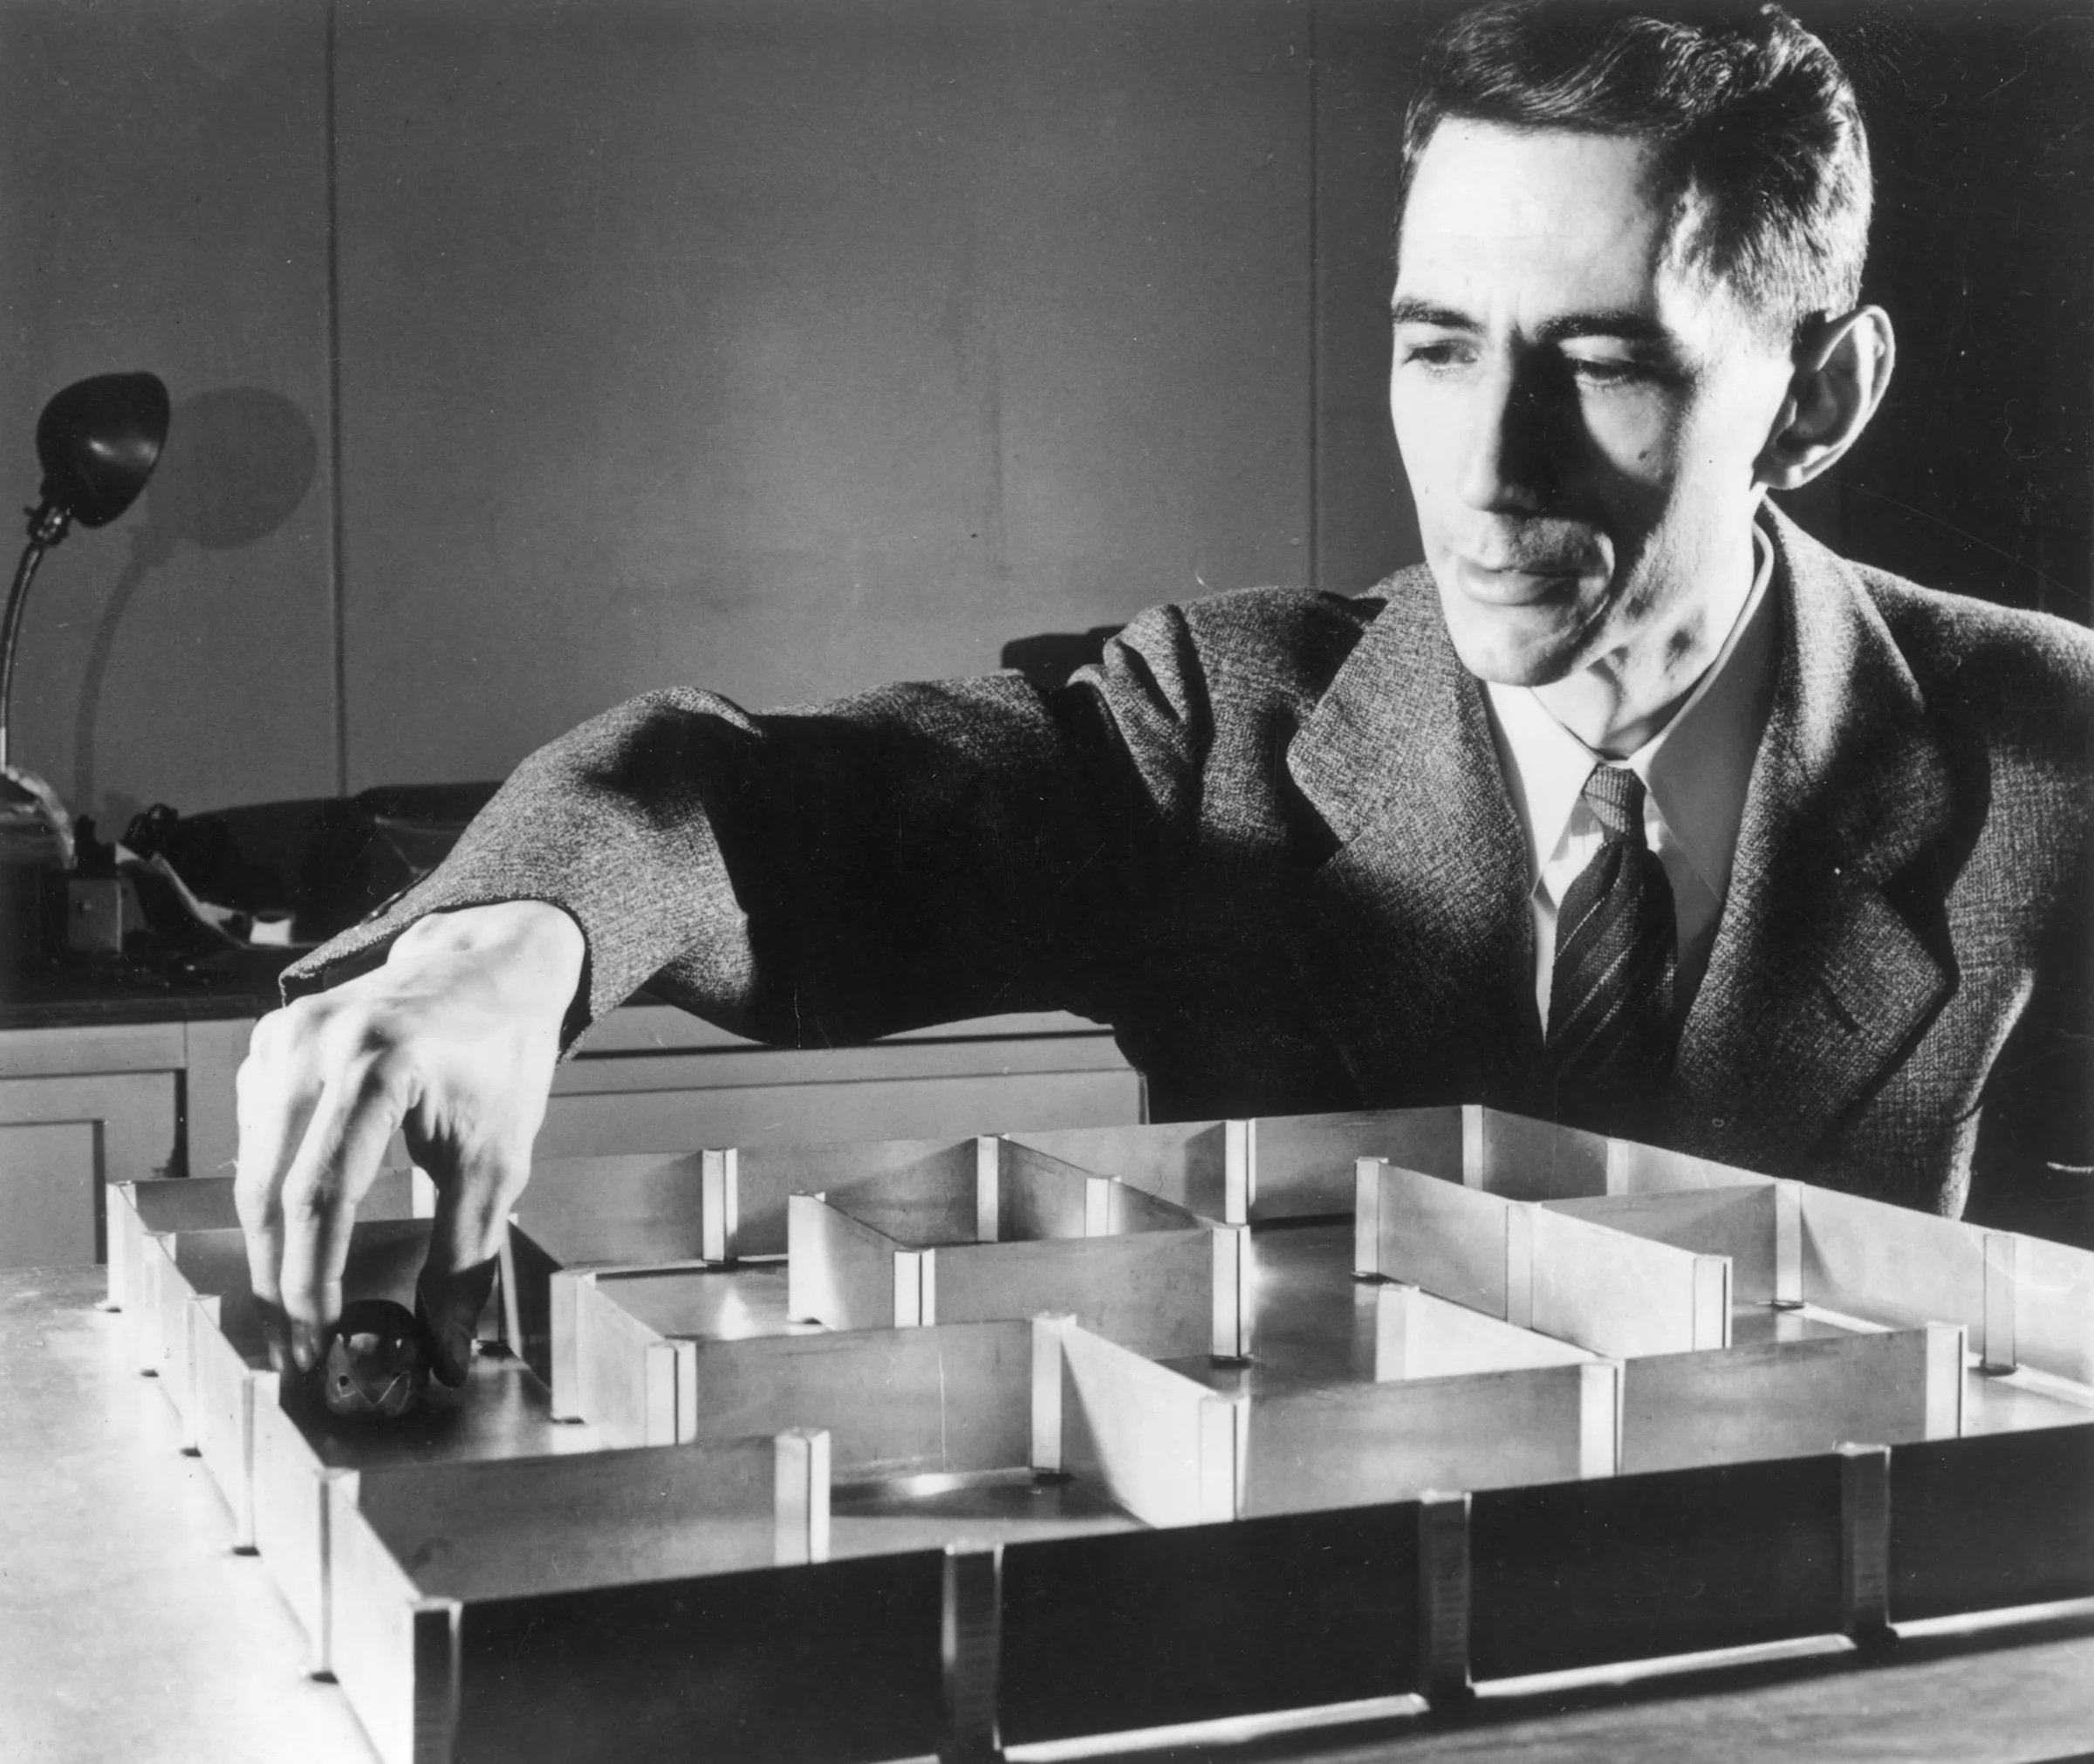

In [3]:
display(img)

# Quick tour of information theory

Claude Shannon (pictured above) was the pioneer of the field of Information Theory, computing, and artificial intelligence. 

We will not cover very much of information theory here, but will hit on the basic concept of "Information", also referred to as [Shannon's Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory))

But first, let's build a little intuition about what entropy is.

Let's imagine that Alice has a sequence of numbers, from 0 to 7 and that she wants to transmit to Bob.  It may look something like this:


In [4]:
message_length = 10000
message = [random.randint(0,7) for i in range(message_length)]
message[:10]

[1, 2, 4, 3, 0, 3, 2, 5, 2, 2]

If we converted each number to binary, we would need to send 3 bits per number. We could then create a new, binary message that looks , like this:

`011,101,000,000,001,000,001,010,100,110 # each individually converted to binary`

`011101000000001000001010100110 # squished together`

In this way, Alice would need 3 "bits per symbol" to send her message to Bob. With 10,000 numbers, she needs 30,000 bits.

But what would happen if the numbers were not uniformly distributed, but some occurred more often than others? Then, maybe there's some way she can be clever in how she sends the message.  After all, if every number was the same, she wouldn't have to say anything except what that one number was?

In [5]:
sample_ratio = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,3,4,5,6,7]
message2 = [random.choice(sample_ratio) for i in range(message_length)]
message2[:10]

[7, 0, 0, 7, 2, 0, 6, 3, 2, 0]

Now, some values are much more common than the others. Let's do a quick comparison of the distributions.

In [6]:
orig_value_counts = Counter(message)
new_value_counts = Counter(message2)

for i in range(8):
    print(i, orig_value_counts[i]/message_length, new_value_counts[i]/message_length)

0 0.1233 0.4968
1 0.1262 0.1836
2 0.1258 0.0919
3 0.127 0.0424
4 0.1174 0.0417
5 0.1249 0.0483
6 0.1289 0.0503
7 0.1265 0.045


Imagine that Alice comes up with a code where each symbol/number she wants to transmit is still unambiguous, but they aren't all uniformly 3-bits? Something like below:

In [7]:
mapping = {0:'0',
           1:'10',
           2:'110',
           3:'1110',
           4:'11110',
           5:'111110',
           6:'1111110',
           7:'11111110',
          }

msg2_coded = [mapping[i] for i in message2]
msg2_coded_bits = ''.join(msg2_coded)
print(msg2_coded[:10])
print(len(msg2_coded_bits))
           

['11111110', '0', '0', '11111110', '110', '0', '1111110', '1110', '110', '0']
25197


She has now saved over 5000 bits!On a per number (symbol) basis, she is down to 2.45 bits/number.  Assuming that Bob has the same codebook, then they can both decode this message.(this encoding scheme is along the lines of [Huffman Coding](https://en.wikipedia.org/wiki/Huffman_coding) )

Note: every time there is a `0` in the string of bits she sends, it signals the end of a symbol. In this way, the most common symbol gets the shortest code of only a single bit. Because it is so common, this very short code for `0` makes up for the fact that the `7` now takes 8 bits, instead of the original 3.

We should be able to calculate the number of bits just based on the counts:

In [8]:
bits = 0

for k,v in new_value_counts.items():
    word = mapping[k]
    bits += v*len(word)
print(bits)

25197


Let's look at what we have here.  Written mathematically, it is like this:

$$ bits = \sum_{i} N_i*wordlength_i $$

What Shannon found was that the optimal wordlength for a symbol is the logarithm of it's probability (base 2):

$$ optimalwordlength = -\log_{2} p_i $$

So, the more frequent a symbol is, the closer this is to 0. Note that this results in _fractional_ bits if the probability is not a (negative) power of 2. This is a form of a theoretical limit, but, amazingly, you can actually encode things with fractional bits using techniques like [Arithmetic Coding](https://en.wikipedia.org/wiki/Arithmetic_coding). We will not discuss that, but it can be super interesting to learn about!

This insight lets us calculate the information content of a message, in terms of the 'bits' needed:

$$ bits = \sum_{i} -N_i * \log_2 p_i $$

or, written as a 'bits per symbol' instead of the total bits:

$$ H = \sum_{i} -p_i * \log_2 p_i $$

This quantity, $H$ is what is known as the _Shannon Entropy_ of the message.

Entropy is a super powerful concept to know about. Let's see how we can apply this in a few different ways.

First, though, let's calculate how good our encoding scheme was above by calculating the space that the optimal encoding scheme would take:

In [9]:
from math import log2

entropy_message1 = 0
entropy_message2 = 0

for i in range(8):
    entropy_message1 -= orig_value_counts[i]*log2(orig_value_counts[i]/message_length)
    entropy_message2 -= new_value_counts[i]*log2(new_value_counts[i]/message_length)

print(entropy_message1, entropy_message2)

## As it turns out, we were not terribly far off of optimal: 22600ish bits vs 24756.

29995.081626577547 22807.800332854018


### Example: predicting the weather

Imagine we are trying to predict whether or not it will rain today. Looking at all the data, we see that it rains 15% of the time. So, the amount of information contained in the rain/no-rain indicator would be:


In [10]:
entropy = -0.15*log2(0.15) - 0.85*log2(0.85)
print(entropy)

0.6098403047164004


So, about 0.6 bits.  But imagine, instead, that we could look outside and see if it was cloudy.  Then, we found the following information:

When it _is_ cloudy, the chance of rain is 50%. When it is _not_ cloudy, the chance of rain is 0.05%

It is cloudy 22.22% of the time.

The chance of rain/no-rain is still the same 15% as before:

In [11]:
chance_rain = 0.2222*(0.5) + (1-0.2222)*0.05
print(chance_rain)

0.14999


But, now that we _know_ whether it is cloudy, what would the information content be in determining if it rains?

In [12]:
entropy = 0
entropy -= (0.2222)*(0.5 *log2(0.5) + 0.5*log2(0.5)) ## Chance of rain/no-rain on cloudy days, weighted by chance of clouds
entropy -= (1 - 0.2222)*(0.05 *log2(0.05) + 0.95*log2(0.95)) ## chance of rain/no-rain on sunny days, weighted by chance of sun
print(entropy)

0.4449595532447908


We are down to 0.44 bits!

mathematically, what we did was:

Or a difference of about 0.16 bits

What this is telling us is that, whether the day is cloudy or not is giving us _information_ about whether it will rain or not.

This difference could be written this way:

$$ M.I. = H(x) - H(x |y) $$
Where _x_ is rain vs no rain and _y_ is clouds vs no clouds

_M.I._ is what is called the Mutual Information. It can be written a few different ways:

$$ M.I. = H(x) - H(x |y) = H(y) - H(y |x) = H(x) + H(y) - H(x,y) $$


For our example of rain/clouds, the _M.I._ is 0.16 bits

Sometimes, it is useful to normalize this value:

$$ MI/H(x) = 0.27 $$
So, in our case, clouds provide 27% of the information related to rain


### As a measure of predictive power

In the same way that the presence of clouds provided information about the rain, allowing us to express rain vs no rain in fewer bits, I could also built a predictor of rain vs no rain.

In that case, x is rain and y is 'predicted rain or predicted no rain'. A better prediction means I need fewer bits to describe what actually happens. So, Mutual Information can be a measure of predictive power.

### Kullback-Leibler Divergence

OK, so if we know the probability of each symbol, __p<sub>i</sub>__ then we can find the optimal encoding using a word length of __log<sub>2</sub> p<sub>i</sub>__

But, what if we used the wrong distribution to make our 'code words'? Imagine, we used some other distribution, __q__ to generate our coding scheme.  Then, our bits per symbol if we encoded our message would look like this:

$$ bits = \sum_i -p_i log_2 q_i $$

because each symbol will occur with __p<sub>i</sub>__ likelihood, but we are using a word length of __log<sub>2</sub> q<sub>i</sub>__

This is going to be bigger than optimal, if __p__ and __q__ are different. How much worse will we be?

$$ D_{KL} = \sum_i -p_i (log_2 q_i  - log_2 p_i ) $$
or
$$ D_{KL} = \sum_i -p_i log_2 \frac{q_i}{p_i}  $$

This is known as the Kullback-Leibler divergence. It tells us how different two distributions are from each other.



## Summary

Information theory, and the various measures related to Entropy are fundamental concepts for many different applications. In this class, we will see it appear in a few different ways:

* Last week, we talked about the Pointwise Mutual Information, which has a slightly different definition than Mutual Information, as a measure of interestingness for co-occurrences in Association Rules
* Mutual Information can be useful to understand which features may provide predictive power over a target
  * Large Language Models are designed to minimize a version of entropy in their predictions of the next token
* KL Divergence is used in constructing decision trees and ensembles of trees
* We could use entropy to describe how well data is separated in clustering


